In [1]:
import joblib
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt

In [ ]:
print("🛰️ LOADING SPACENET DATA...")
images = joblib.load('../data/spacenet/ims.np')
masks = joblib.load('../data/spacenet/mas.np')

print(f"✅ Raw data loaded:")
print(f"Images: {images.shape}, dtype: {images.dtype}")
print(f"Masks: {masks.shape}, dtype: {masks.dtype}")

🛰️ LOADING SPACENET DATA...
✅ Raw data loaded:
Images: (1260, 1024, 1024, 4), dtype: uint8
Masks: (1260, 1024, 1024), dtype: uint8


In [3]:
print("🔍 DATA QUALITY CHECK:")
print(f"Missing pixels in images: {np.isnan(images).sum()}")
print(f"Missing pixels in masks: {np.isnan(masks).sum()}")

black_images = np.all(images == 0, axis=(1,2,3)).sum()
print(f"Completely black images: {black_images}")

print(f"Same number of images/masks: {len(images) == len(masks)}")

🔍 DATA QUALITY CHECK:
Missing pixels in images: 0
Missing pixels in masks: 0
Completely black images: 15
Same number of images/masks: True


In [4]:
print("🛠️ REMOVING BLACK IMAGES...")
valid_indices = []
for i in range(len(images)):
    if not np.all(images[i] == 0):
        valid_indices.append(i)

images_clean = images[valid_indices]
masks_clean = masks[valid_indices]

print(f"✅ Removed {len(images) - len(images_clean)} black images")
print(f"Clean data: {images_clean.shape}")

🛠️ REMOVING BLACK IMAGES...
✅ Removed 15 black images
Clean data: (1245, 1024, 1024, 4)


In [5]:
def resize_batch(images, masks, new_size=(256, 256)):
    X_resized = []
    y_resized = []
    
    for i in range(len(images)):
        img_resized = cv2.resize(images[i], new_size, interpolation=cv2.INTER_AREA)
        mask_resized = cv2.resize(masks[i], new_size, interpolation=cv2.INTER_NEAREST)
        X_resized.append(img_resized)
        y_resized.append(mask_resized)
    
    return np.array(X_resized), np.array(y_resized)

print("🖼️ RESIZING IMAGES...")
X_resized, y_resized = resize_batch(images_clean, masks_clean)
print(f"✅ Resized to: {X_resized.shape}")

🖼️ RESIZING IMAGES...
✅ Resized to: (1245, 256, 256, 4)


In [6]:
print("🔢 NORMALIZING DATA...")
X_normalized = X_resized.astype('float32') / 255.0
y_binary = (y_resized > 0).astype('float32')

print(f"✅ Normalized - Images: [{X_normalized.min():.3f}, {X_normalized.max():.3f}]")
print(f"✅ Binary masks - Unique: {np.unique(y_binary)}")

🔢 NORMALIZING DATA...
✅ Normalized - Images: [0.000, 1.000]
✅ Binary masks - Unique: [0. 1.]


In [7]:
print("📊 SPLITTING DATA...")
X_train, X_val, y_train, y_val = train_test_split(
    X_normalized, y_binary, test_size=0.2, random_state=42, shuffle=True
)

print(f"✅ Split complete:")
print(f"Training: {X_train.shape}, {y_train.shape}")
print(f"Validation: {X_val.shape}, {y_val.shape}")

📊 SPLITTING DATA...
✅ Split complete:
Training: (996, 256, 256, 4), (996, 256, 256)
Validation: (249, 256, 256, 4), (249, 256, 256)


In [ ]:
print("💾 SAVING PROCESSED DATA...")
np.save('../data/spacenet/X_train.npy', X_train)
np.save('../data/spacenet/X_val.npy', X_val)
np.save('../data/spacenet/y_train.npy', y_train) 
np.save('../data/spacenet/y_val.npy', y_val)

print("🎉 SPACENET DATA PROCESSED AND SAVED!")

💾 SAVING PROCESSED DATA...
🎉 SPACENET DATA PROCESSED AND SAVED!


👀 VISUALIZING SAMPLE DATA...


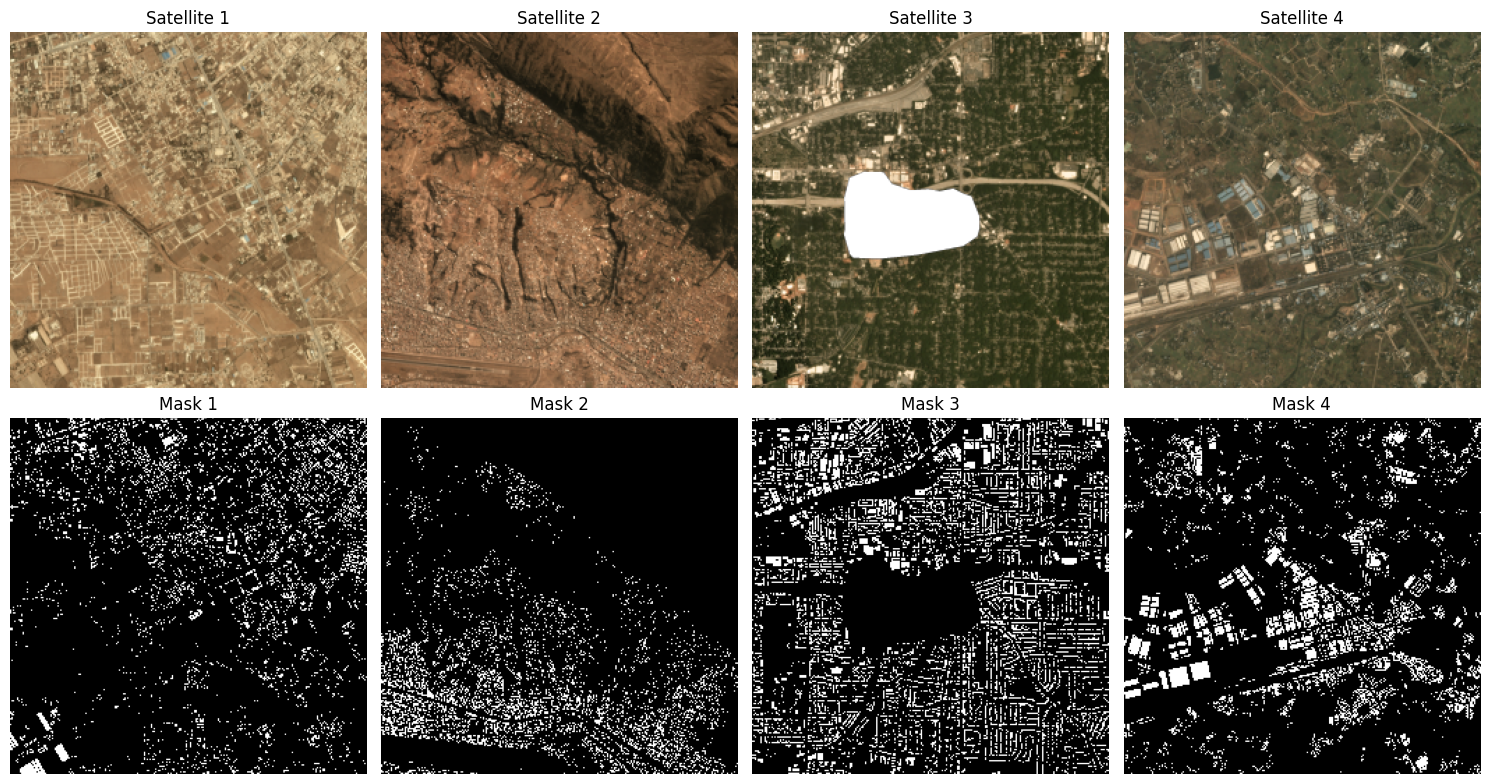

In [9]:
print("👀 VISUALIZING SAMPLE DATA...")
fig, axes = plt.subplots(2, 4, figsize=(15, 8))

for i in range(4):
    axes[0, i].imshow(X_train[i])
    axes[0, i].set_title(f'Satellite {i+1}')
    axes[0, i].axis('off')
    
    axes[1, i].imshow(y_train[i], cmap='gray')
    axes[1, i].set_title(f'Mask {i+1}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

In [11]:
print("📁 LOADING PROCESSED DATA...")
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
X_val = np.load('X_val.npy')
y_val = np.load('y_val.npy')

print(f"✅ Data loaded:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_val: {y_val.shape}")

# Add channel dimension to masks
y_train = np.expand_dims(y_train, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)
print(f"✅ Masks reshaped: {y_train.shape}")

📁 LOADING PROCESSED DATA...
✅ Data loaded:
X_train: (996, 256, 256, 4)
y_train: (996, 256, 256)
X_val: (249, 256, 256, 4)
y_val: (249, 256, 256)
✅ Masks reshaped: (996, 256, 256, 1)


In [12]:
def iou(y_true, y_pred, smooth=1e-6):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
    union = tf.reduce_sum(y_true, axis=[1,2,3]) + tf.reduce_sum(y_pred, axis=[1,2,3]) - intersection
    return tf.reduce_mean((intersection + smooth) / (union + smooth))

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
    denom = tf.reduce_sum(y_true, axis=[1,2,3]) + tf.reduce_sum(y_pred, axis=[1,2,3])
    return tf.reduce_mean((2. * intersection + smooth) / (denom + smooth))

In [13]:
def build_unet(input_shape=(256, 256, 4)):
    inputs = Input(input_shape)
    
    # Encoder
    c1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(32, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D(2)(c1)
    
    c2 = Conv2D(64, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(64, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D(2)(c2)
    
    c3 = Conv2D(128, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(128, 3, activation='relu', padding='same')(c3)
    
    # Decoder
    u4 = UpSampling2D(2)(c3)
    u4 = concatenate([u4, c2])
    c4 = Conv2D(64, 3, activation='relu', padding='same')(u4)
    c4 = Conv2D(64, 3, activation='relu', padding='same')(c4)
    
    u5 = UpSampling2D(2)(c4)
    u5 = concatenate([u5, c1])
    c5 = Conv2D(32, 3, activation='relu', padding='same')(u5)
    c5 = Conv2D(32, 3, activation='relu', padding='same')(c5)
    
    outputs = Conv2D(1, 1, activation='sigmoid')(c5)
    return Model(inputs, outputs)

print("🏗️ BUILDING U-NET MODEL...")
model = build_unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', iou, dice_coef])
print(f"✅ Model built! Parameters: {model.count_params():,}")

🏗️ BUILDING U-NET MODEL...
✅ Model built! Parameters: 471,841


In [14]:
print("🚀 STARTING TRAINING...")
history = model.fit(
    X_train, y_train,
    batch_size=4,
    epochs=15,
    validation_data=(X_val, y_val),
    verbose=1
)
print("✅ Training completed!")

🚀 STARTING TRAINING...
Epoch 1/15
249/249 ━━━━━━━━━━━━━━━━━━━━ 358s 1s/step - accuracy: 0.9253 - dice_coef: 1.2716e-04 - iou: 6.6590e-05 - loss: 0.2667 - val_accuracy: 0.9199 - val_dice_coef: 1.2227e-09 - val_iou: 1.2227e-09 - val_loss: 0.2633
Epoch 2/15
249/249 ━━━━━━━━━━━━━━━━━━━━ 328s 1s/step - accuracy: 0.9254 - dice_coef: 4.0591e-05 - iou: 2.0374e-05 - loss: 0.2459 - val_accuracy: 0.9199 - val_dice_coef: 2.5255e-04 - val_iou: 1.2643e-04 - val_loss: 0.2511
Epoch 3/15
249/249 ━━━━━━━━━━━━━━━━━━━━ 292s 1s/step - accuracy: 0.9258 - dice_coef: 0.0172 - iou: 0.0094 - loss: 0.2411 - val_accuracy: 0.9202 - val_dice_coef: 0.0088 - val_iou: 0.0044 - val_loss: 0.2479
Epoch 4/15
249/249 ━━━━━━━━━━━━━━━━━━━━ 294s 1s/step - accuracy: 0.9261 - dice_coef: 0.0323 - iou: 0.0176 - loss: 0.2393 - val_accuracy: 0.9211 - val_dice_coef: 0.0427 - val_iou: 0.0223 - val_loss: 0.2478
Epoch 5/15
249/249 ━━━━━━━━━━━━━━━━━━━━ 315s 1s/step - accuracy: 0.9262 - dice_coef: 0.0310 - iou: 0.0166 - loss: 0.2388 - va

In [15]:
print("💾 SAVING MODEL...")
model.save('../../models/unet_building_segmentation.h5')
print("✅ Real U-Net model saved!")

💾 SAVING MODEL...
✅ Real U-Net model saved!


🔍 TESTING PREDICTIONS...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


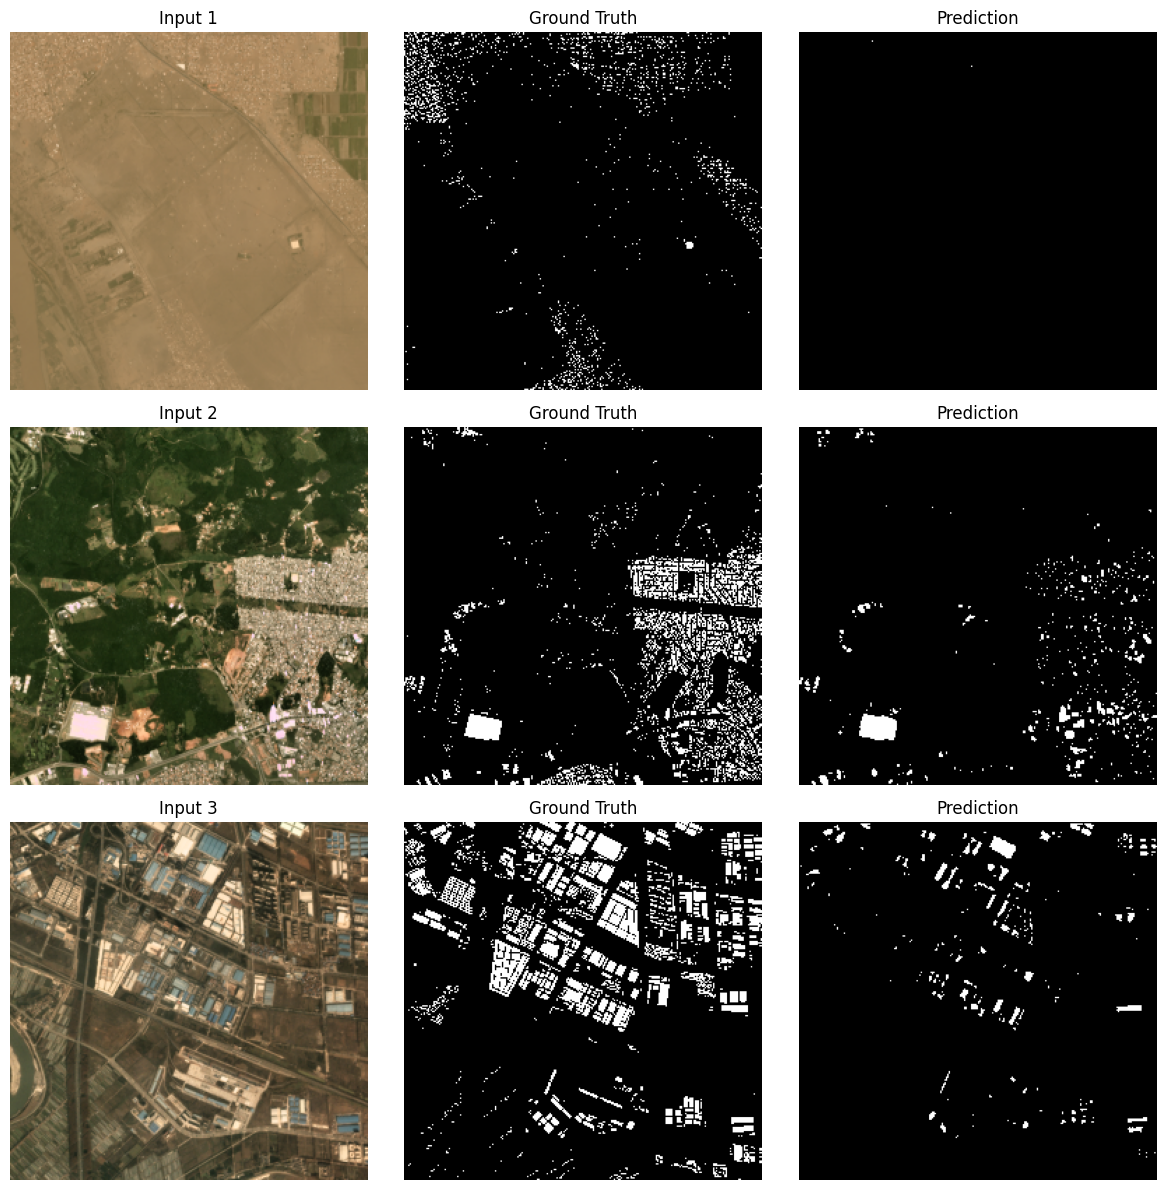

In [16]:
print("🔍 TESTING PREDICTIONS...")
preds = model.predict(X_val[:3])

# Visualize results
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for i in range(3):
    axes[i, 0].imshow(X_val[i][:,:,:3])
    axes[i, 0].set_title(f'Input {i+1}')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(y_val[i].squeeze(), cmap='gray')
    axes[i, 1].set_title('Ground Truth')
    axes[i, 1].axis('off')
    
    axes[i, 2].imshow((preds[i].squeeze() > 0.5), cmap='gray')
    axes[i, 2].set_title('Prediction')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()